# Toxic Comment Classification using NLP

This notebook implements a **multi-label classification model** to identify toxic language in online comments.  
The categories include:

- 💢 Toxic
- 🤬 Obscene
- ⚠️ Threat
- 😡 Insult
- 🧿 Identity Hate
- ☣️ Severe Toxic



### 1. Load and explore the dataset

In [9]:
# ==== CORE UTILITIES ====
import numpy as np
import pandas as pd
import re as regex_lib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

# ==== VISUALIZATION ====
from wordcloud import WordCloud

# ==== NLP ====
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import SnowballStemmer as Stemmer

# ==== SKLEARN TOOLKIT ====
from sklearn.model_selection import train_test_split as split_data
from sklearn.feature_extraction.text import TfidfVectorizer as TFIDF
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression as LogRegModel
from sklearn.naive_bayes import MultinomialNB as NaiveBayes
from sklearn.ensemble import RandomForestClassifier as RFModel
from sklearn.metrics import (
    roc_auc_score as auc_metric,
    accuracy_score,
    classification_report as generate_report
)

# ==== SETUP ====
nltk.download("stopwords")
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ashwin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# === Load Dataset ===
def import_dataset(filepath):
    """Load the comment dataset from a CSV file."""
    return pd.read_csv(filepath)

# Load and preview the dataset
comments_df = import_dataset("train.csv")
comments_df.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### 2. Visualize and understand label distributions

In [18]:
# === Dataset Summary ===
print("Dataset Shape:", comments_df.shape)
print("\nData Types and Null Values:\n")
print(comments_df.info())

Dataset Shape: (159571, 8)

Data Types and Null Values:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
None


In [13]:
print("\nBasic Stats:\n")
print(comments_df.describe())


Basic Stats:

               toxic   severe_toxic        obscene         threat  \
count  159571.000000  159571.000000  159571.000000  159571.000000   
mean        0.095844       0.009996       0.052948       0.002996   
std         0.294379       0.099477       0.223931       0.054650   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

              insult  identity_hate  
count  159571.000000  159571.000000  
mean        0.049364       0.008805  
std         0.216627       0.093420  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max         1.000000       1.000000  


In [14]:
# === Missing Values ===
print("\nMissing Values:\n")
print(comments_df.isnull().sum())


Missing Values:

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


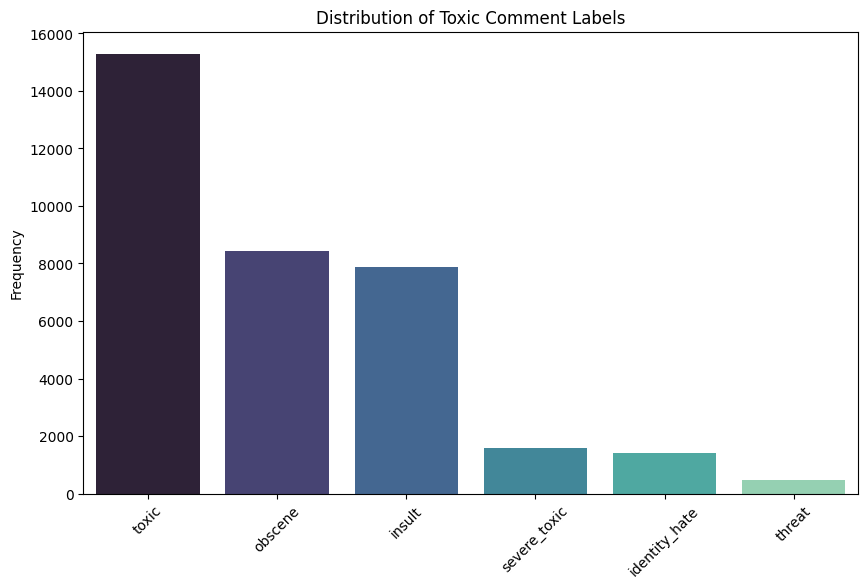

In [17]:
# === Label Distribution ===
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
label_counts = comments_df[label_columns].sum().sort_values(ascending=False)

# Plot label frequencies
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="mako")
plt.title("Distribution of Toxic Comment Labels")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


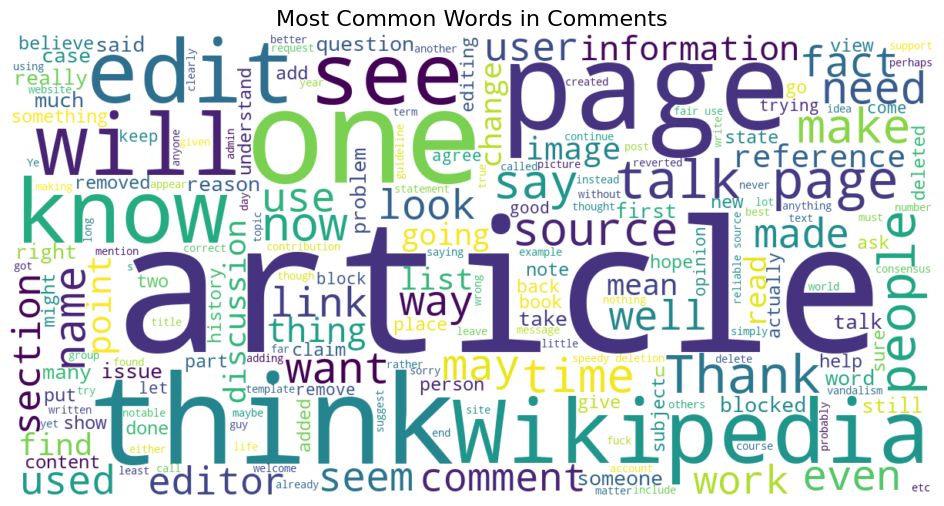

In [20]:
# === Word Cloud Generator ===
def visualize_word_cloud(text_data, title="Word Cloud"):
    text_string = " ".join(text_data)
    wc = WordCloud(width=1200, height=600, background_color="white").generate(text_string)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"{title}", fontsize=16)
    plt.show()

# Display word cloud for all comments
visualize_word_cloud(comments_df["comment_text"].astype(str), "Most Common Words in Comments")


### 3. Preprocess comment text using NLP

In [21]:
# === Text Preprocessing Setup ===
nltk_stopwords_list = set(nltk_stopwords.words("english"))
text_stemmer = Stemmer("english")

def sanitize_text(raw_text):
    """Clean, lowercase, remove stopwords, and apply stemming."""
    if not isinstance(raw_text, str):
        return ""
    
    # Remove non-letter characters
    cleaned = regex_lib.sub(r"[^a-zA-Z]", " ", raw_text)
    
    # Convert to lowercase and tokenize
    tokens = cleaned.lower().split()
    
    # Remove stopwords and apply stemming
    processed = [text_stemmer.stem(word) for word in tokens if word not in nltk_stopwords_list]
    
    return " ".join(processed)

# Apply cleaning
comments_df["clean_text"] = comments_df["comment_text"].apply(sanitize_text)
comments_df[["comment_text", "clean_text"]].head(3)


,comment_text,clean_text
0,Explanation\nWhy the edits made under my usern...,explan edit made usernam hardcor metallica fan...
1,D'aww! He matches this background colour I'm s...,aww match background colour seem stuck thank t...
2,"Hey man, I'm really not trying to edit war. It...",hey man realli tri edit war guy constant remov...


### 4. Build and compare multiple classification models

In [22]:
# === Prepare Features and Labels ===
features = comments_df["clean_text"]
targets = comments_df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]

# === Split Data ===
X_train, X_test, y_train, y_test = split_data(
    features, targets, test_size=0.25, random_state=42
)

# === Define Model Pipelines ===
def create_pipeline(model):
    """Create a scikit-learn pipeline with TFIDF vectorizer and classifier."""
    return Pipeline([
        ("vectorizer", TFIDF(stop_words="english", max_df=0.7)),
        ("classifier", OneVsRestClassifier(model))
    ])


In [23]:
# === Initialize Models ===
models_dict = {
    "Naive Bayes": create_pipeline(NaiveBayes()),
    "Logistic Regression": create_pipeline(LogRegModel(solver='liblinear', C=1.0)),
    "Random Forest": create_pipeline(RFModel(n_estimators=100, random_state=42))
}

trained_models = {}

# === Train All Models ===
for model_name, pipeline in models_dict.items():
    print(f"Training model: {model_name}")
    pipeline.fit(X_train, y_train)
    trained_models[model_name] = pipeline


Training model: Naive Bayes
Training model: Logistic Regression
Training model: Random Forest


### 5. Evaluate model performance using AUC and classification metrics

In [24]:
# === Model Evaluation Function ===
def evaluate_model(pipeline, y_true, y_pred_probs, label_names):
    print("Classification Report:\n")
    print(generate_report(y_true, y_pred_probs > 0.5, target_names=label_names))
    
    print("\nROC AUC Scores:")
    for i, label in enumerate(label_names):
        auc_score = auc_metric(y_true.iloc[:, i], y_pred_probs[:, i])
        print(f"{label}: {auc_score:.4f}")

# === Run Evaluation for Each Model ===
for name, model in trained_models.items():
    print(f"\n{'='*40}\n Evaluation for: {name}\n{'='*40}")
    y_preds = model.predict_proba(X_test)
    evaluate_model(model, y_test, y_preds, targets.columns.tolist())



 Evaluation for: Naive Bayes
Classification Report:

               precision    recall  f1-score   support

        toxic       0.99      0.21      0.35      3815
 severe_toxic       0.00      0.00      0.00       406
      obscene       0.99      0.13      0.23      2143
       threat       0.00      0.00      0.00       105
       insult       0.96      0.06      0.11      2011
identity_hate       0.00      0.00      0.00       357

    micro avg       0.99      0.14      0.24      8837
    macro avg       0.49      0.07      0.11      8837
 weighted avg       0.88      0.14      0.23      8837
  samples avg       0.02      0.01      0.01      8837


ROC AUC Scores:
toxic: 0.8911
severe_toxic: 0.8997
obscene: 0.8871
threat: 0.7994
insult: 0.8765
identity_hate: 0.8155

 Evaluation for: Logistic Regression
Classification Report:

               precision    recall  f1-score   support

        toxic       0.92      0.62      0.74      3815
 severe_toxic       0.59      0.27      0.37 

### 6. Predict toxicity on unseen comments

In [25]:
# === Test with New Example Comments ===
example_comments = [
    "You are a disgrace to humanity.",
    "I hope you have a wonderful day!",
    "You stupid idiot, no one likes you.",
    "This is an informative post. Thanks for sharing!"
]

# === Choose Best Model (say Logistic Regression) ===
final_model = trained_models["Logistic Regression"]

# Clean and predict
cleaned_examples = [sanitize_text(comment) for comment in example_comments]
predicted_output = final_model.predict(cleaned_examples)

# Show Results
for comment, prediction in zip(example_comments, predicted_output):
    print(f"Comment: {comment}")
    print("Predicted Labels:", dict(zip(targets.columns, prediction)))


Comment: You are a disgrace to humanity.
Predicted Labels: {'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}
Comment: I hope you have a wonderful day!
Predicted Labels: {'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}
Comment: You stupid idiot, no one likes you.
Predicted Labels: {'toxic': 1, 'severe_toxic': 0, 'obscene': 1, 'threat': 0, 'insult': 1, 'identity_hate': 0}
Comment: This is an informative post. Thanks for sharing!
Predicted Labels: {'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}
